In [ ]:
!git clone https://github.com/MicheleCattaneo/ant_colony_opt_TSP.git

Cloning into 'ant_colony_opt_TSP'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 151 (delta 75), reused 107 (delta 36), pack-reused 0 (from 0)
Receiving objects: 100% (151/151), 4.41 MiB | 16.50 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [ ]:
cd ant_colony_opt_TSP

/content/ant_colony_opt_TSP


Running Iteration #1...
  Distance: 727.15 | Steps: 91 | Time: 33.46s
  GIF saved as hc_tsp_1.gif
Running Iteration #2...
  Distance: 967.62 | Steps: 65 | Time: 21.47s
  GIF saved as hc_tsp_2.gif
Running Iteration #3...
  Distance: 784.02 | Steps: 84 | Time: 31.99s
  GIF saved as hc_tsp_3.gif
Running Iteration #4...
  Distance: 833.01 | Steps: 69 | Time: 23.41s
  GIF saved as hc_tsp_4.gif
Running Iteration #5...
  Distance: 848.65 | Steps: 79 | Time: 28.64s
  GIF saved as hc_tsp_5.gif


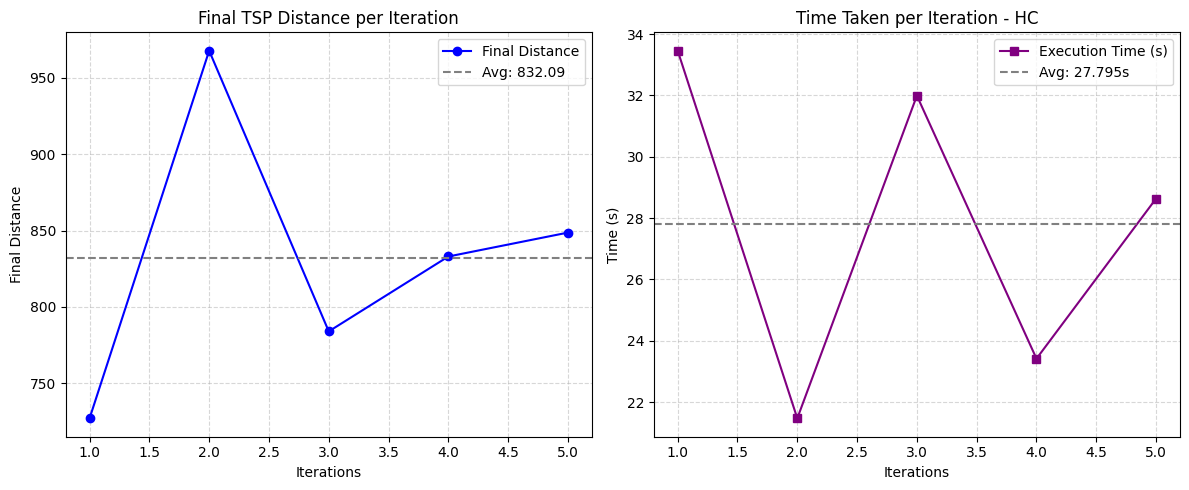

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import imageio.v2 as imageio
import os
import shutil
import time

def function_parse_tsp(file_path):
    """
    Parses a TSP file to extract city coordinates.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    coordinates = []
    node_coord_section = False
    for line in lines:
        if line.startswith('NODE_COORD_SECTION'):
            node_coord_section = True
            continue
        if line.startswith('EOF'):
            break
        if node_coord_section:
            parts = line.strip().split()
            coordinates.append((float(parts[1]), float(parts[2])))
    return coordinates

def dist_euclidean(coordinates):
    """
    Calculates a Euclidean distance matrix between all cities.
    """
    num_cities = len(coordinates)
    distance_matrix = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            distance_matrix[i][j] = np.linalg.norm(
                np.array(coordinates[i]) - np.array(coordinates[j]))
    return distance_matrix

def total_distance(tour, dist_matrix):
    """
    Computes total distance of a given tour based on a distance matrix.
    """
    # Calculating the total distance of a tour which forms a cycle
    total_distance = 0

    # We sum the distances between consecutive nodes in the tour
    for i in range(len(tour) - 1):
        total_distance += dist_matrix[tour[i]][tour[i + 1]]

    # Adding return distance from last node to first
    total_distance += dist_matrix[tour[-1]][tour[0]]

    return total_distance

def expand(tour):
    """
    Generates all neighbors of a tour by swapping each pair of cities.
    """
    neighbors = []
    for i in range(len(tour)):
        for j in range(i+1, len(tour)):
            neighbor = tour.copy()
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
            neighbors.append(neighbor)
    return neighbors

def plot_tour_gif(coords, tour, step, folder='frames'):
    """
    Plots and saves the current tour to disk to build a GIF later.
    """
    coords_arr = np.array([coords[i] for i in tour + [tour[0]]])

    plt.figure(figsize=(6, 4))
    plt.plot(coords_arr[:, 0], coords_arr[:, 1], 'b-', marker='o')

    for i, (x, y) in enumerate(coords_arr[:-1]):
        plt.text(x, y, str(tour[i]), fontsize=8, color='red')

    plt.title("Hill Climbing Step {}".format(step))
    plt.grid(True)
    os.makedirs(folder, exist_ok=True)

    filename = os.path.join(folder, 'step_{:03d}.png'.format(step))

    plt.savefig(filename)
    plt.close()

def hill_climbing(coords, max_steps=100, folder='frames'):
    """
    Runs the Hill Climbing algorithm on the TSP and visualizes each step.
    """

    dist_matrix = dist_euclidean(coords)

    current_tour = list(range(len(coords)))
    random.shuffle(current_tour)

    current_dist = total_distance(current_tour, dist_matrix)

    step_counter = 0

    plot_tour_gif(coords, current_tour, step_counter, folder)

    for _ in range(1, max_steps + 1):
        neighbors = expand(current_tour)
        next_tour = min(neighbors, key=lambda t: total_distance(t, dist_matrix))
        next_dist = total_distance(next_tour, dist_matrix)

        if next_dist < current_dist:
            current_tour = next_tour
            current_dist = next_dist
            step_counter += 1
            plot_tour_gif(coords, current_tour, step_counter, folder)
        else:
            break

    return current_tour, current_dist, step_counter

def generate_gif(frame_folder='frames', output_file='hill_climbing_tsp.gif'):
    """
    Combines all saved frames into a single GIF animation.
    """
    images = []
    files = sorted(os.listdir(frame_folder))
    for file in files:
        if file.endswith('.png'):
            img_path = os.path.join(frame_folder, file)
            images.append(imageio.imread(img_path))
    imageio.mimsave(output_file, images, duration=3)
    print("  GIF saved as {}".format(output_file))

def clear_frame_folder(folder='frames'):
    """
    Clears any previous frame images and recreates the folder.
    """
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

def visualize_results(iterations, distances, times):
    """
    Plots a summary of the optimization runs including distance and time.
    """

    def create_plot(x, y, avg, ylabel, label_leg, title, color, marker, filename, y_suffix=""):
        plt.figure()
        plt.plot(x, y, marker=marker, linestyle='-', color=color, label=label_leg)
        plt.axhline(y=avg, color='gray', linestyle='--', label="Avg: {:.4f}{}".format(avg, y_suffix))
        plt.xlabel("Iterations")
        plt.ylabel(ylabel)
        plt.title(title)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        plt.tight_layout()
        plt.savefig(filename, dpi=300)
        plt.close()

    x_vals = list(range(1, iterations + 1))
    avg_dist = sum(distances) / len(distances)
    avg_time = sum(times) / len(times)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(x_vals, distances, marker='o', color='blue', label='Final Distance')
    axs[0].axhline(y=avg_dist, color='gray', linestyle='--', label="Avg: {:.2f}".format(avg_dist))
    axs[0].set_title("Final TSP Distance per Iteration")
    axs[0].set_xlabel("Iterations")
    axs[0].set_ylabel("Final Distance")
    axs[0].legend()
    axs[0].grid(True, linestyle='--', alpha=0.5)

    axs[1].plot(x_vals, times, marker='s', color='purple', label='Execution Time (s)')
    axs[1].axhline(y=avg_time, color='gray', linestyle='--', label="Avg: {:.3f}s".format(avg_time))
    axs[1].set_title("Time Taken per Iteration - HC")
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel("Time (s)")
    axs[1].legend()
    axs[1].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig("hill_climbing_summary.png", dpi=300)
    plt.show()

    create_plot(x_vals, distances, avg_dist, "Final Distance", "Final Distance",
                "Final TSP Distance per Iteration", 'blue', 'o', "hill_distance_plot.png")

    create_plot(x_vals, times, avg_time, "Execution Time (s)", "Execution Time",
                "Time Taken per Iteration - HC", 'purple', 's', "hill_time_plot.png", y_suffix="s")

# === TSP Execution ===
path_tsp = '/content/ant_colony_opt_TSP/problems_cleaned/eil76.tsp'
coords = function_parse_tsp(path_tsp)

run_times = []
final_distances = []

for run in range(1, 6):
    print("Running Iteration #{:d}...".format(run))
    folder = 'frames_iteration{}'.format(run)
    clear_frame_folder(folder)

    start_time = time.time()
    tour, dist, steps = hill_climbing(coords, folder=folder)
    end_time = time.time()
    elapsed = end_time - start_time

    run_times.append(elapsed)
    final_distances.append(dist)

    print("  Distance: {:.2f} | Steps: {} | Time: {:.2f}s".format(dist, steps, elapsed))

    generate_gif(frame_folder=folder, output_file='hc_tsp_{}.gif'.format(run))

visualize_results(5, final_distances, run_times)
